In [2]:
!pip install tensorflow

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/fonttools-4.51.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/DimondPricePrediction-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 2.0 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 2.3 MB/s et

In [2]:
import numpy as np
import tensorflow as tf
import logging

# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Select only samples corresponding to digits 0 and 1
train_mask = (train_labels == 0) | (train_labels == 1)
test_mask = (test_labels == 0) | (test_labels == 1)

train_images_01 = train_images[train_mask]
test_images_01 = test_images[test_mask]
train_labels_01 = train_labels[train_mask]
test_labels_01 = test_labels[test_mask]

# Map labels to -1 and 1
train_labels_01 = np.where(train_labels_01 == 0, -1, 1)
test_labels_01 = np.where(test_labels_01 == 0, -1, 1)

# Normalize pixel values to range [0, 1]
train_images_01 = train_images_01 / 255.0
test_images_01 = test_images_01 / 255.0

# Reshape images to 2D tensors
train_images_01 = train_images_01.reshape((-1, 28*28))
test_images_01 = test_images_01.reshape((-1, 28*28))

# Split train set into train and val set
val_samples_per_class = 1000

train_indices_0 = np.where(train_labels_01 == -1)[0]
train_indices_1 = np.where(train_labels_01 == 1)[0]

np.random.shuffle(train_indices_0)
np.random.shuffle(train_indices_1)

val_indices_0 = train_indices_0[:val_samples_per_class]
val_indices_1 = train_indices_1[:val_samples_per_class]

train_indices_0 = train_indices_0[val_samples_per_class:]
train_indices_1 = train_indices_1[val_samples_per_class:]

train_images_train = np.concatenate([train_images_01[train_indices_0], train_images_01[train_indices_1]])
train_labels_train = np.concatenate([train_labels_01[train_indices_0], train_labels_01[train_indices_1]])

val_images = np.concatenate([train_images_01[val_indices_0], train_images_01[val_indices_1]])
val_labels = np.concatenate([train_labels_01[val_indices_0], train_labels_01[val_indices_1]])

# Shuffle train set
train_indices = np.arange(train_images_train.shape[0])
np.random.shuffle(train_indices)
train_images_train = train_images_train[train_indices]
train_labels_train = train_labels_train[train_indices]

# Shuffle val set
val_indices = np.arange(val_images.shape[0])
np.random.shuffle(val_indices)
val_images = val_images[val_indices]
val_labels = val_labels[val_indices]

# Print shapes
print("Training images shape:", train_images_train.shape)
print("Training labels shape:", train_labels_train.shape)
print("Test images shape:", test_images_01.shape)
print("Test labels shape:", test_labels_01.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)


Training images shape: (10665, 784)
Training labels shape: (10665,)
Test images shape: (2115, 784)
Test labels shape: (2115,)
Validation images shape: (2000, 784)
Validation labels shape: (2000,)


In [3]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components_ = None

    def fit(self, X):
        X_centered = X - np.mean(X, axis=0)

        covariance_matrix = np.cov(X_centered, rowvar=False)

        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        self.components_ = sorted_eigenvectors[:, :self.n_components]

    def transform(self, X):
        return np.dot(X, self.components_)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(train_images_train)
X_train_reduced = pca.transform(train_images_train)
X_test_reduced = pca.transform(val_images)
X_test_rd=pca.transform(test_images_01)

In [3]:
def find_best_split(X,y,wt):
  best_err=float('inf')
  best_split_dim=None
  best_split_val=None
  best_split_side=None

  for dim in range(X.shape[1]):
    unique_val=np.unique(X[:,dim])
    unique_val=np.sort(unique_val)
    mid_pts=(unique_val[:-1]+unique_val[1:])/2

    for split_val in mid_pts:
      lf_idx=X[:,dim]<=split_val
      rt_idx=~lf_idx

      lf_wt=wt[lf_idx]
      rt_wt=wt[rt_idx]

      lf_err=np.sum(lf_wt*(y[lf_idx]!=-1))
      rt_err=np.sum(rt_wt*(y[rt_idx]!=1))
      total_err=lf_err+rt_err

      if total_err<best_err:
        best_err=total_err
        best_split_dim=dim
        best_split_val=split_val
        best_split_side=(lf_idx,rt_idx)
  return best_split_dim,best_split_val,best_split_side

In [4]:
def train_Dt_stump(X,y,wt):
  best_split_dim,best_split_val,best_split_side=find_best_split(X,y,wt)
  stump={
      'split_dim':best_split_dim,
      'split_val':best_split_val,
      'left_idx':best_split_side[0],
      'right_idx':best_split_side[1]
  }
  return stump

In [5]:
def pred(stump,X):
  predictions=np.zeros(len(X))
  predictions[X[:, stump['split_dim']] <= stump['split_val']] = -1
  predictions[X[:, stump['split_dim']] > stump['split_val']] = 1
  return predictions

In [25]:
logging.basicConfig(filename='stump_training.log', level=logging.INFO, format='%(message)s')
n_stumps=300
wts=np.full(len(X_train_reduced), 1/len(X_train_reduced))
alphas=np.zeros(n_stumps)
val_set_accuracy=[]
for i in range(n_stumps):
  stump=train_Dt_stump(X_train_reduced,train_labels_train,wts)
  y_pred=pred(stump, X_train_reduced)
  error = np.sum(wts * (y_pred != train_labels_train))
  alphas[i] = 0.5 * np.log((1 - error) / error)
  wts *= np.exp(-alphas[i] * train_labels_train * y_pred)
  wts /= np.sum(wts)

  y_pred_val=pred(stump, X_test_reduced)
  accuracy=np.mean(y_pred_val==val_labels)
  val_set_accuracy.append(accuracy)
  print("Alpha_{}: {}, Validation Accuracy: {:.4f}".format(i+1, alphas[i],accuracy))
  logging.info("Alpha_{}: {}, Validation Accuracy: {:.4f}".format(i+1, alphas[i], accuracy))  

Alpha_1: 0.45794847678312567, Validation Accuracy: 0.6990
Alpha_2: 0.3451298878217005, Validation Accuracy: 0.5790
Alpha_3: 0.3111697006232536, Validation Accuracy: 0.6265
Alpha_4: 0.21757100518821218, Validation Accuracy: 0.5665
Alpha_5: 0.20618376123827492, Validation Accuracy: 0.6960
Alpha_6: 0.17510698179912365, Validation Accuracy: 0.5120
Alpha_7: 0.13533795499330567, Validation Accuracy: 0.6255
Alpha_8: 0.17867635231712753, Validation Accuracy: 0.5740
Alpha_9: 0.13484274106807898, Validation Accuracy: 0.6035
Alpha_10: 0.1433292664633878, Validation Accuracy: 0.5050
Alpha_11: 0.14571826851632574, Validation Accuracy: 0.6970
Alpha_12: 0.12507178493504303, Validation Accuracy: 0.5000
Alpha_13: 0.12160819408951166, Validation Accuracy: 0.6005
Alpha_14: 0.1045606546380623, Validation Accuracy: 0.5000
Alpha_15: 0.10958676536006762, Validation Accuracy: 0.6960
Alpha_16: 0.10168271877355556, Validation Accuracy: 0.5570
Alpha_17: 0.08296394670212671, Validation Accuracy: 0.5870
Alpha_18: 

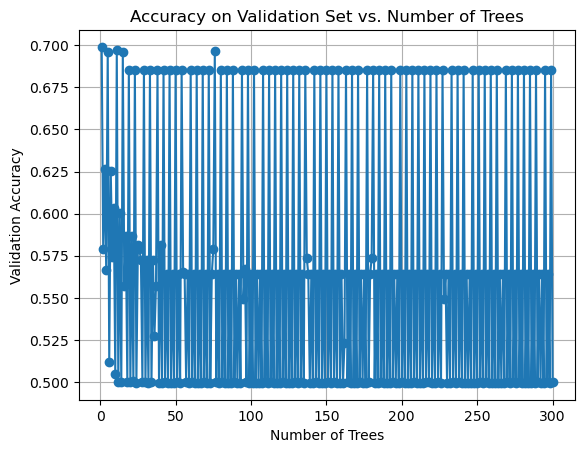

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(1, n_stumps+1), val_set_accuracy, marker='o',linestyle='-')
plt.xlabel('Number of Trees')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy on Validation Set vs. Number of Trees')
plt.grid(True)
plt.show()

In [19]:
wt=np.full(len(X_train_reduced), 1/len(X_train_reduced))
stump=train_Dt_stump(X_train_reduced,train_labels_train,wt)

In [20]:
y_pred=pred(stump, X_train_reduced)
error = np.sum(wt * (y_pred != train_labels_train))
alpha = 0.5 * np.log((1 - error) / error)
wt *= np.exp(-alpha * train_labels_train * y_pred)
wt /= np.sum(wt)


In [21]:
alpha

0.45794847678312567

In [13]:
stump2=train_Dt_stump(X_train_reduced,train_labels_train,wt)
y_pred2=pred(stump2, X_train_reduced)
error2 = np.sum(wt * (y_pred2 != train_labels_train))
alpha2 = 0.5 * np.log((1 - error2) / error2)

In [14]:
alpha2

0.3451298878217005

In [22]:
np.mean(y_pred==train_labels_train)

0.7142053445850914

In [23]:
y_pred_test=pred(stump, X_test_rd)
test_accuracy=np.mean(y_pred_test==test_labels_01)

In [24]:
test_accuracy

0.7130023640661939